# Clustering UMAP graph vs. 2-paths graph

In [1]:
!git branch

* main


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

from partition_igraph import community_ecg as ecg
from community import community_louvain, modularity
import leidenalg as la
import igraph as ig

sns.set()

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [4]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [5]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75, by='Dim Reduction', baselines=None):
    if(baselines is not None):
        if(len(score_types)!=len(baselines)):
            raise ValueError('Need to same length for score_types and baselines')
    else:
        baselines = [0]*len(score_types)
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe[by].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe[by] == dim_red)
            ]
            nb_method = sub_dataframe.shape[0]
            axs[i].bar(
                x=x_positions[:nb_method],
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions[:nb_method] = x_positions[:nb_method] + bar_width
        x_positions[nb_method:] = x_positions[nb_method:] + 0.5*bar_width
    for i in range(len(score_types)):
        axs[i].axhline(baselines[i])
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

In [6]:
def plot_scores_over_x(results_dataframe, x, y, hue, plot_types_column ='Score Type' ,plot_types=("ARI", "AMI"), colors=list(sns.color_palette()), baselines=None):
    if(baselines is not None):
        if(len(plot_types)!=len(baselines)):
            raise ValueError('Need to same length for plot_types and baselines')
    else:
        baselines = [0]*len(plot_types)
    fig, axs = plt.subplots(1, len(plot_types), figsize=(8 * len(plot_types), 8))
    
    for i in range(len(plot_types)):
        df = results_dataframe[results_dataframe[plot_types_column]==plot_types[i]]
        axs[i].set_ylim([0, 1.05])
        sns.barplot(data=df, x=x, y=y, hue=hue, ax=axs[i])
        axs[i].axhline(baselines[i])
        
    fig.tight_layout()

In [7]:
def run_graph_clustering_algorithm(algo_list, G, weight = 'weight'):
    clusterings = dict()
    for algo in algo_list:
        #print(f"Running {algo}...")
        if algo == 'Louvain':
            clusterings[algo] = G.community_multilevel()
        elif algo == 'Louvain \n+ weight':
            clusterings[algo] = G.community_multilevel(weights = weight)
        elif algo == 'Label \nPropagation':
            clusterings[algo] = G.community_label_propagation()
        elif algo == 'ECG':
            clusterings[algo] = G.community_ecg()
        elif algo == 'Leiden':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition)
        elif algo == 'Leiden \n+ weight':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition, weights=weight)
            
        cluster_labels = {algo:np.array(cluster.membership) for algo, cluster in clusterings.items()}
    return(clusterings, cluster_labels)       

In [8]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [9]:
def evaluate_on_non_noise(clustering_labels_dict, skip_eval):
    clustering_noise = dict()
    for name, labels in clustering_labels_dict.items():
        new_labels = labels.copy()
        new_labels[skip_eval] = -1
        clustering_noise[name] = new_labels
    return(clustering_noise)

In [10]:
def print_summary(cluster_labels, G):
    for method, cluster in cluster_labels.items():
        print(f"{method}: \n\tModularity: {G.modularity(cluster):.2f}, \n\tPartition size: {1+max(cluster)}") 

In [11]:
algo_list = ['Louvain', 'Louvain \n+ weight', 'Label \nPropagation', 'ECG', 'Leiden', 'Leiden \n+ weight']
algo_list2 = ['Louvain',  'Louvain \n+ weight', 'Leiden', 'Leiden \n+ weight']

# Compare graph algorithms performance on different graph constructions

In [120]:
def graph_clustering_on_graph_variants(dataset_id, algo_list):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))

    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    ari = adjusted_rand_score(targets, hd_umap_labels)
    ami = adjusted_mutual_info_score(targets, hd_umap_labels)
    print(f'{sum(hd_umap_labels<0)} noise vertices according to HDBSCAN')

    results = []
    # Graph from fuzzy union
    G, A, dists = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1, return_all=True)
    clusterings, clustering_labels  = run_graph_clustering_algorithm(algo_list, G)
    graph_results = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results_union = graph_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
    graph_results_union["Graph"] = 'UMAP graph'
    results.append(graph_results_union)
    
    # length-2 paths graph
    A2 = A*A
    G = ig.Graph.Weighted_Adjacency(A2).as_undirected(mode='collapse', combine_edges={'weight':max})
    clusterings, clustering_labels  = run_graph_clustering_algorithm(algo_list, G)
    graph_results = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results_union = graph_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
    graph_results_union["Graph"] = '2-path graph'
    results.append(graph_results_union)

    results_df = pd.concat(results)

    plot_scores(results_df, by='Graph', baselines=[ari,ami])
    plt.show()

## pendigits

37 noise vertices according to HDBSCAN


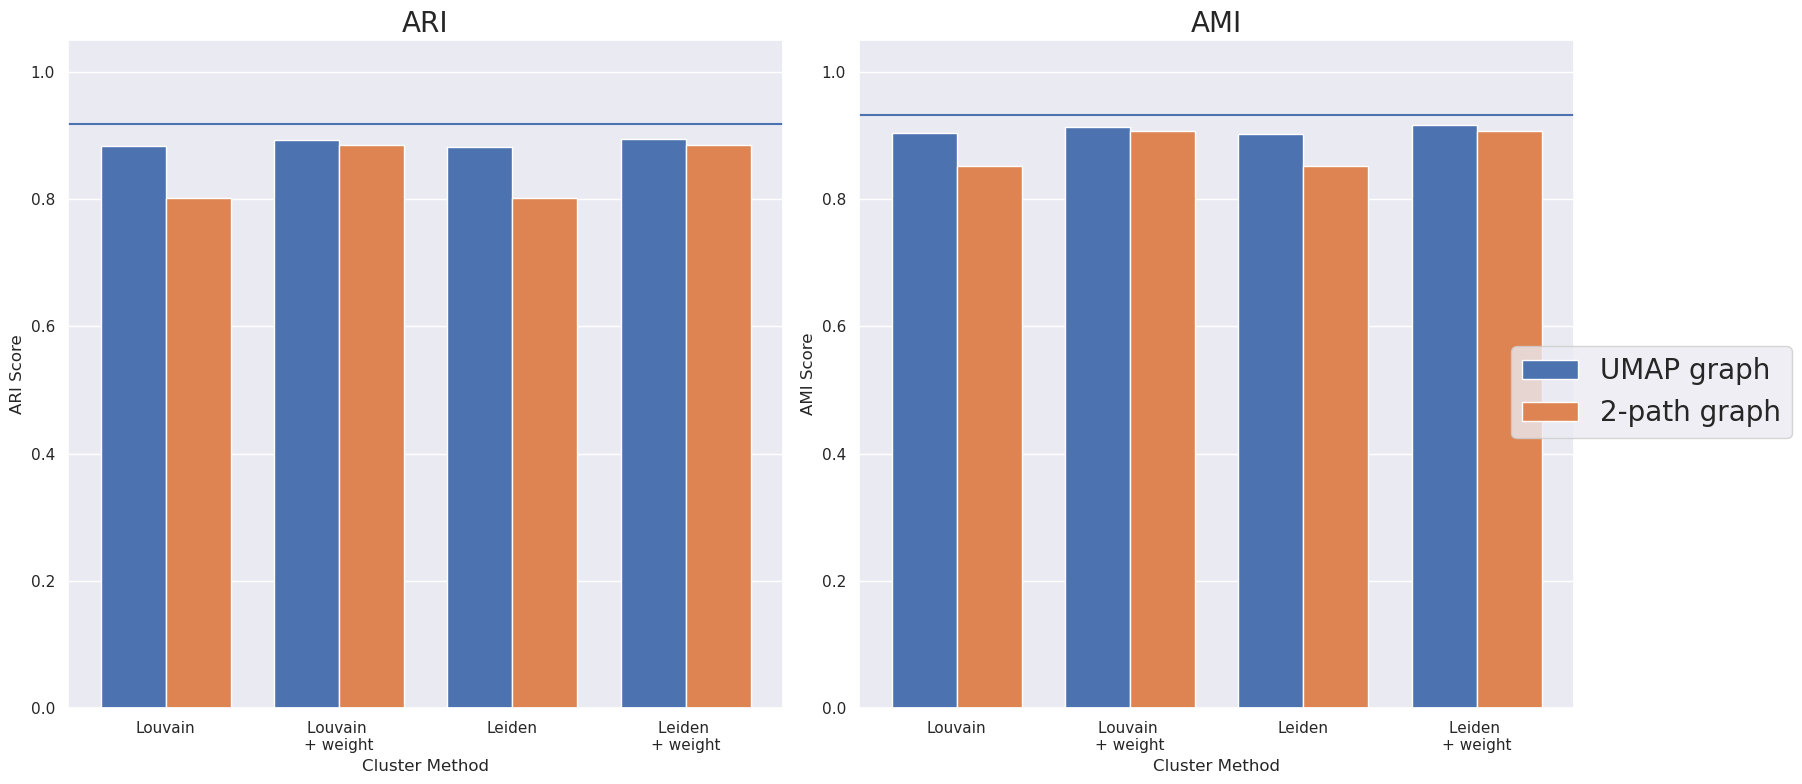

## coil

14 noise vertices according to HDBSCAN


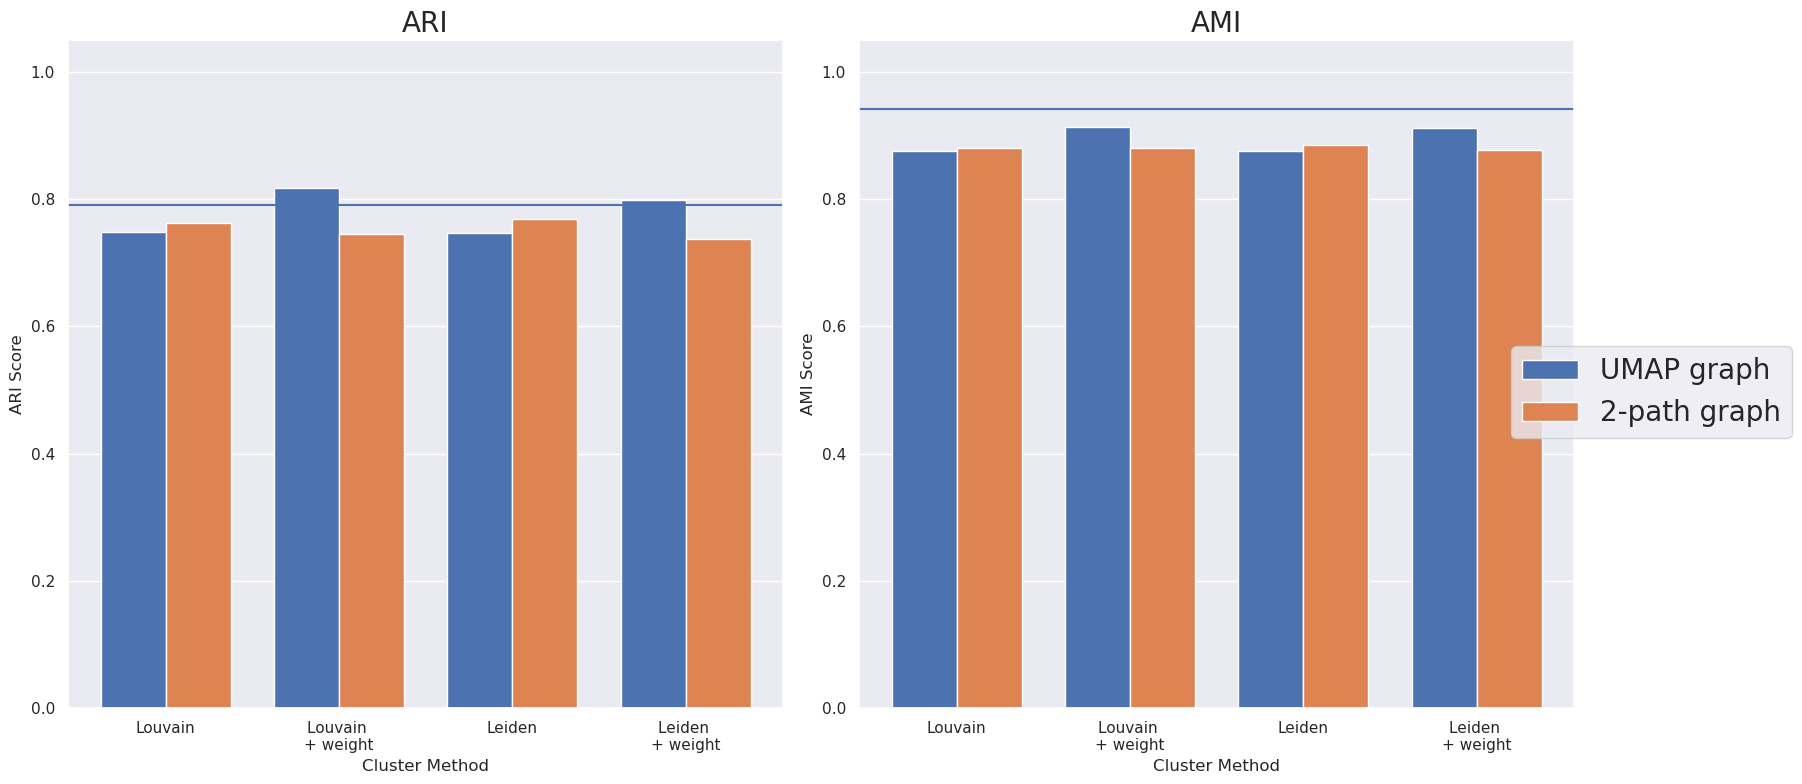

## mnist

483 noise vertices according to HDBSCAN


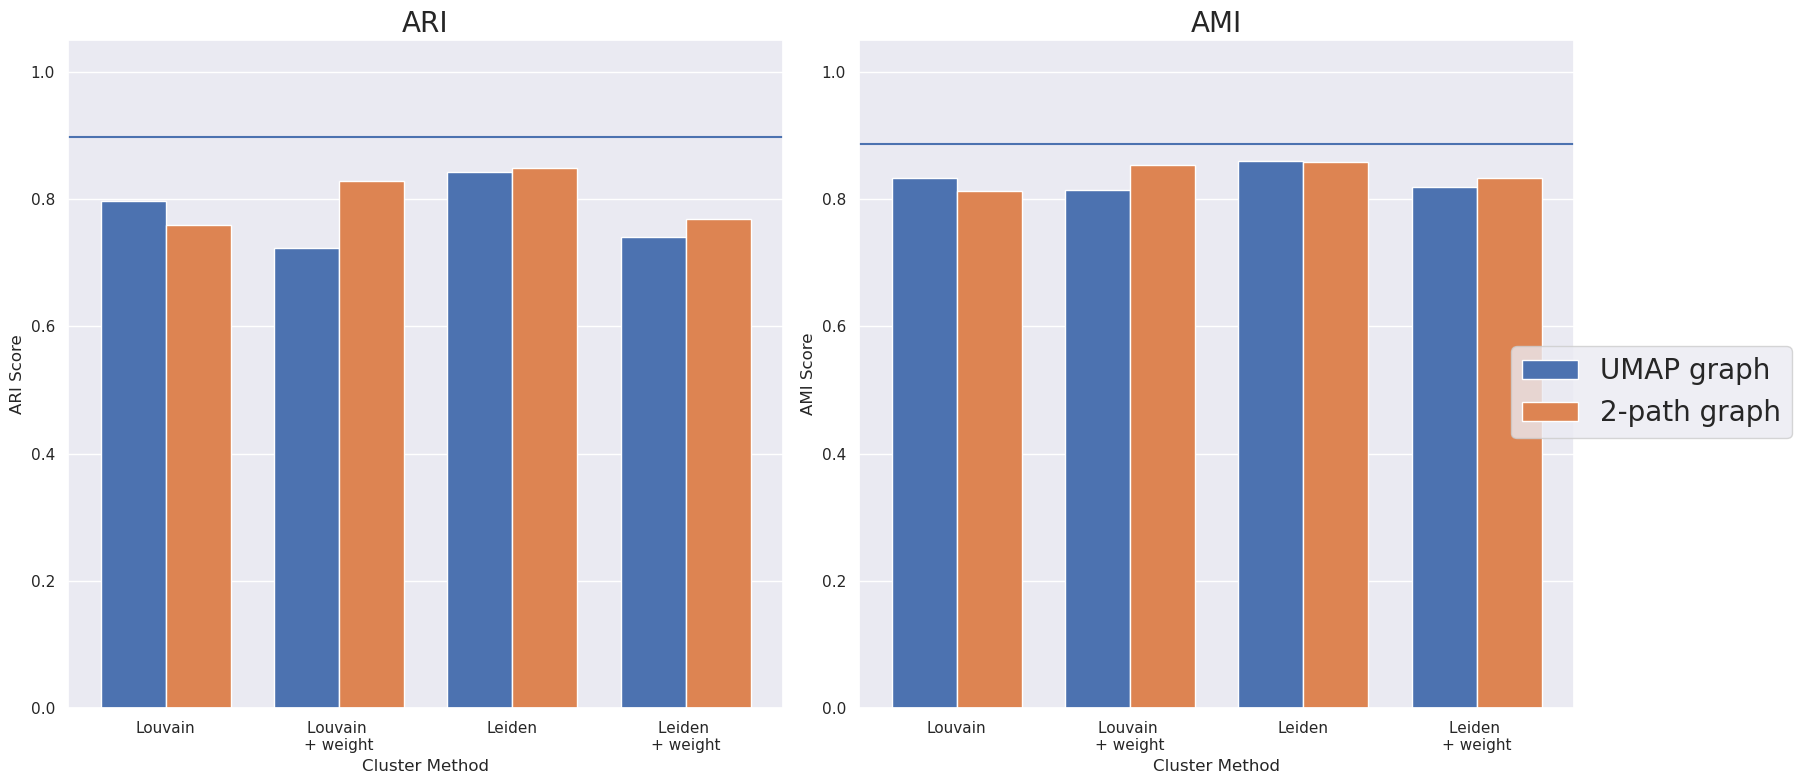

## usps

4 noise vertices according to HDBSCAN


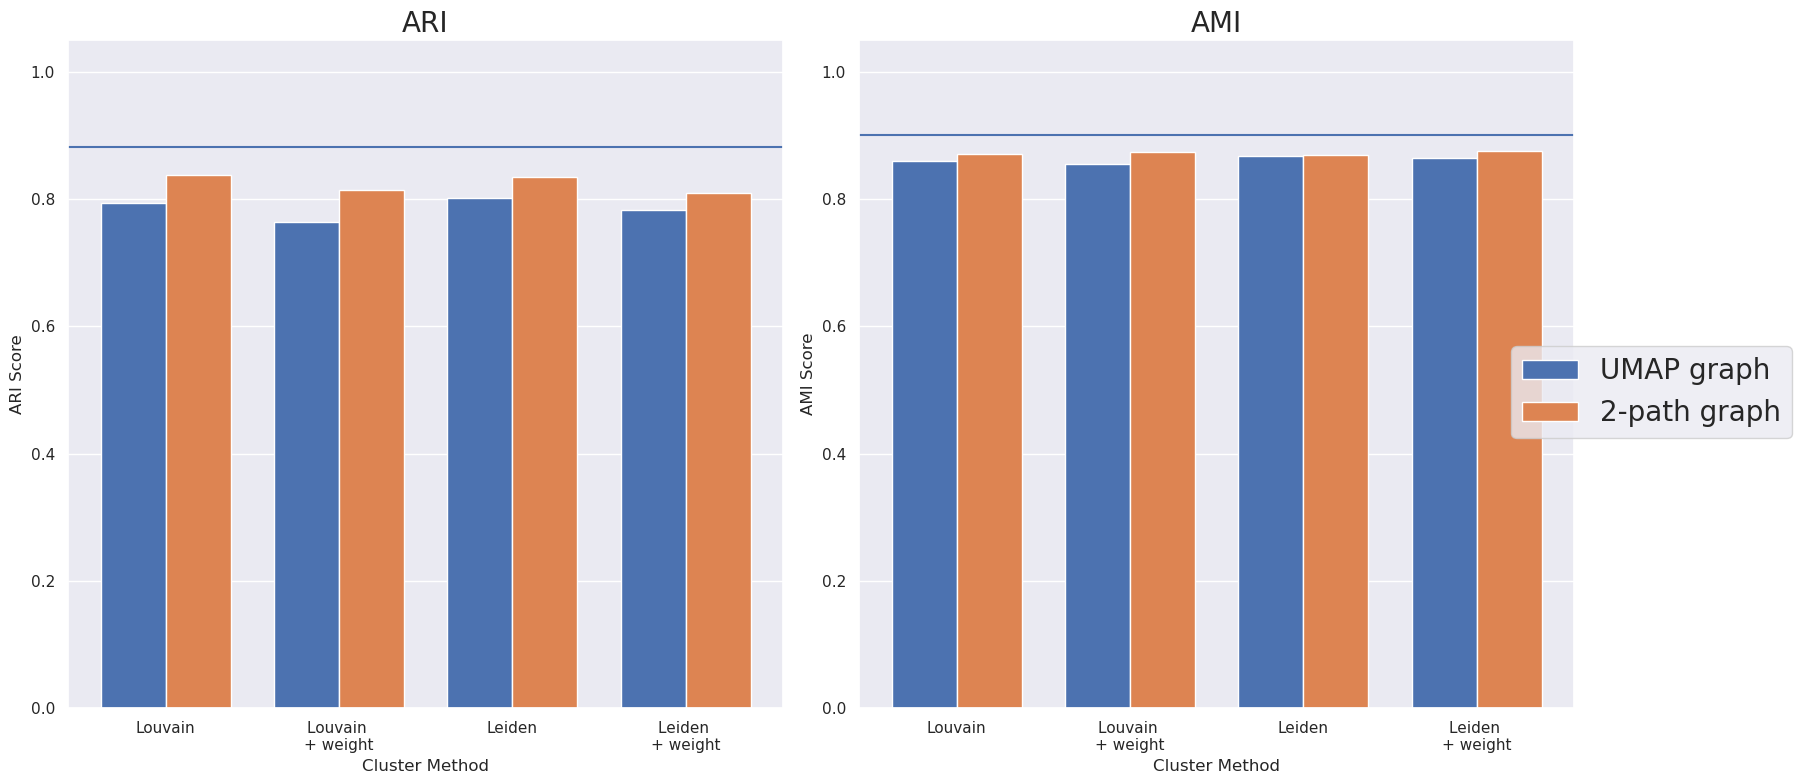

## buildings

363 noise vertices according to HDBSCAN


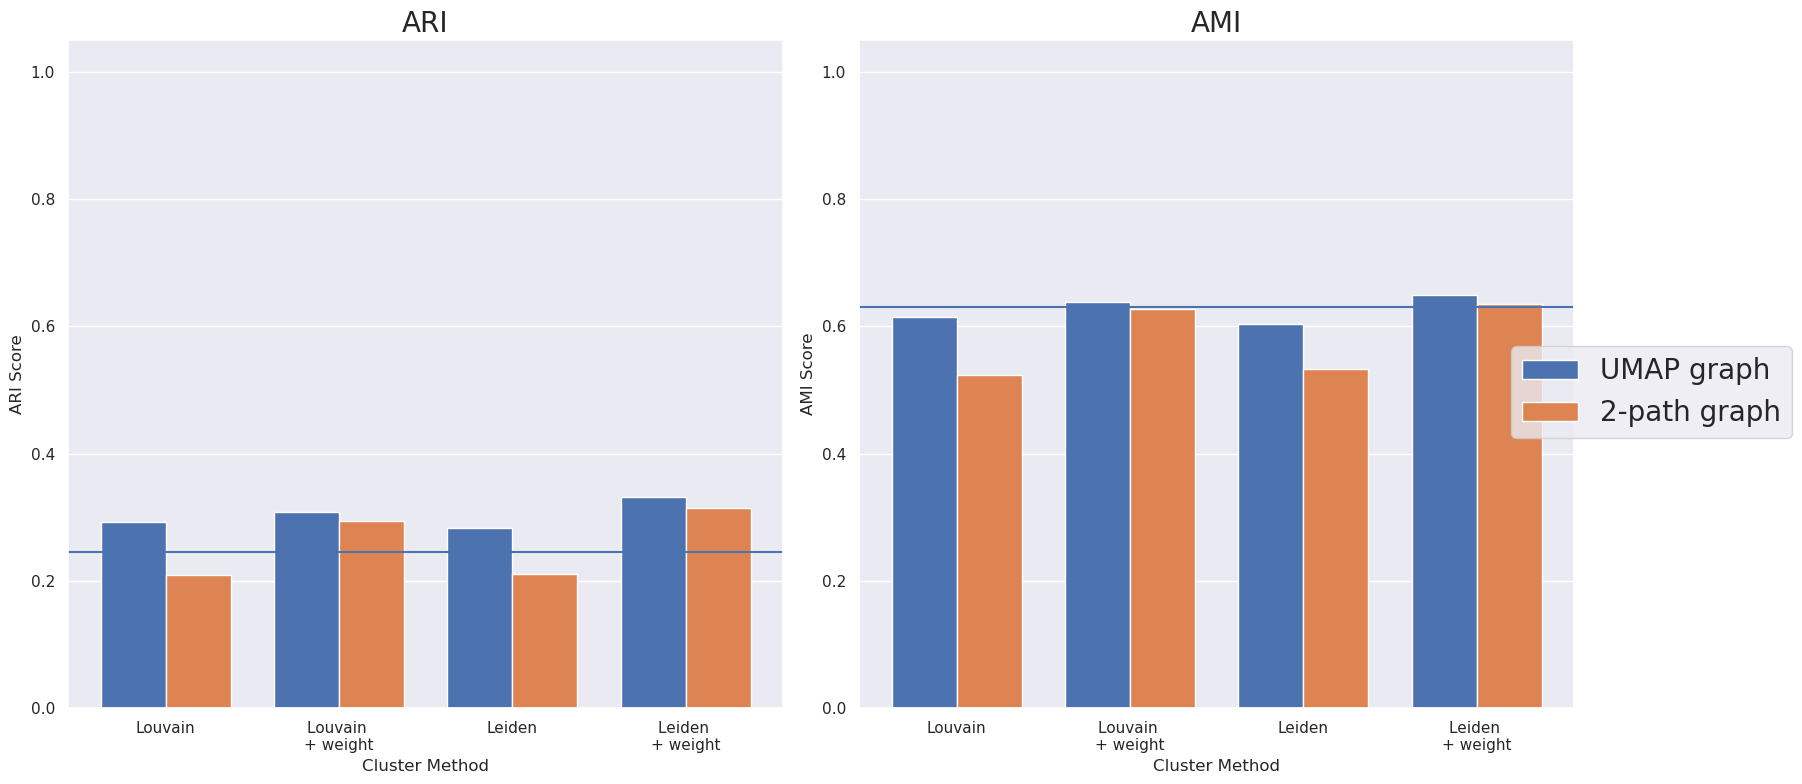

## clusterable

263 noise vertices according to HDBSCAN


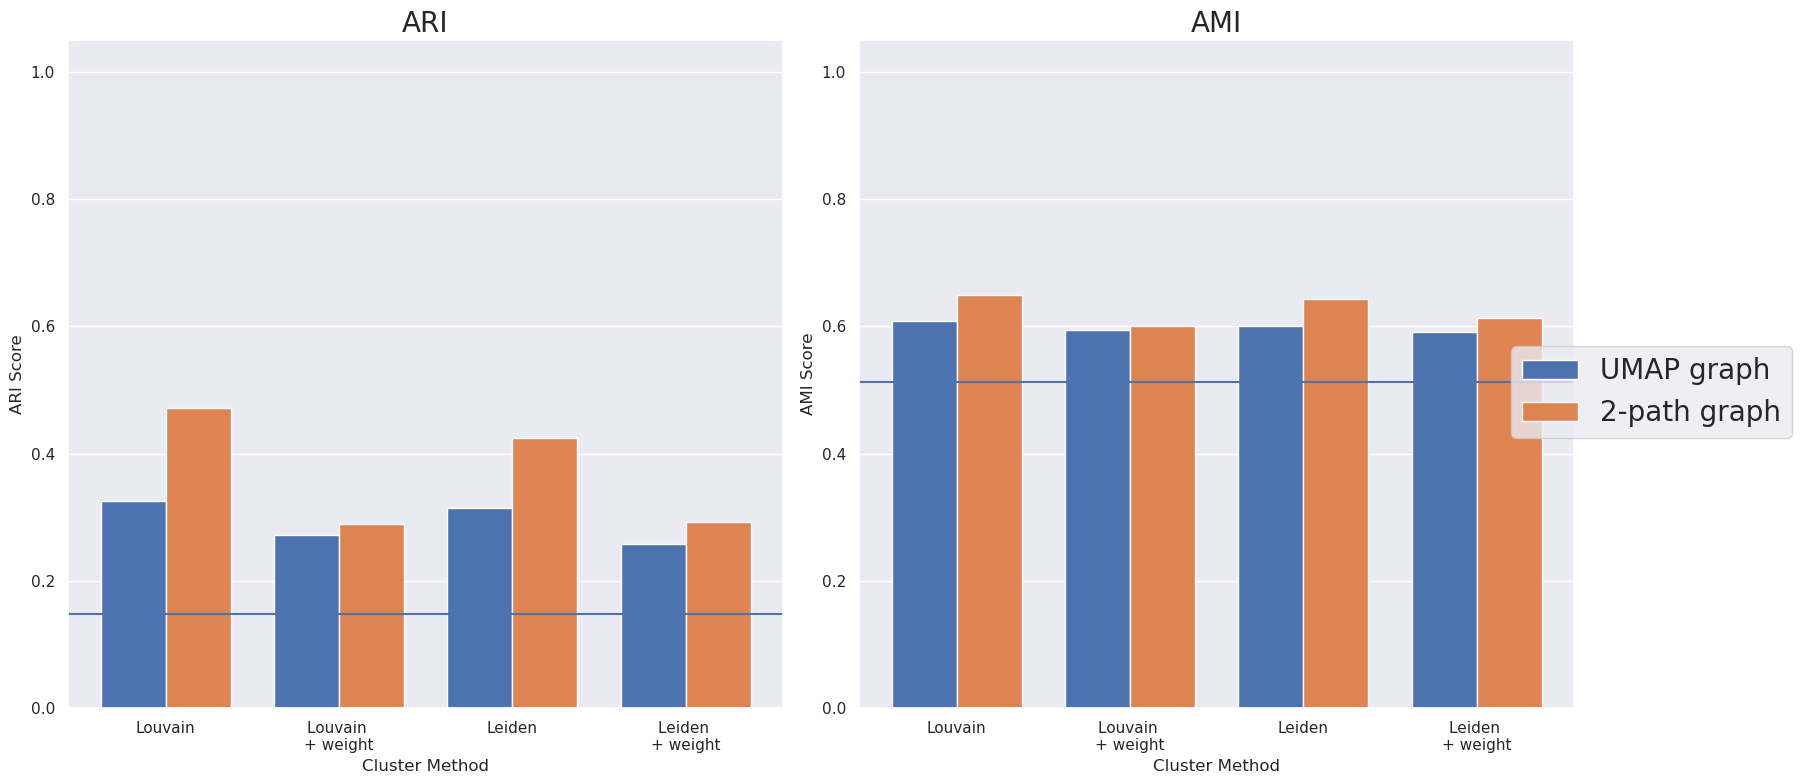

In [122]:
import warnings
warnings.filterwarnings('ignore')
for i in range(6):
    graph_clustering_on_graph_variants(dataset_id=i, algo_list=algo_list2)